<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li></ul></div>

# Dataset

[FBI:UCR Crime dataset](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls)

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

# Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn import linear_model
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

sns.set_style('white')

#Load data
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls',
                   header=4)

#Take a look at the data
print(df.head(10))

                       City  Population  Violent\ncrime  \
0             Adams Village      1861.0             0.0   
1  Addison Town and Village      2577.0             3.0   
2             Akron Village      2846.0             3.0   
3                    Albany     97956.0           791.0   
4            Albion Village      6388.0            23.0   
5            Alfred Village      4089.0             5.0   
6          Allegany Village      1781.0             3.0   
7              Amherst Town    118296.0           107.0   
8        Amityville Village      9519.0             9.0   
9                 Amsterdam     18182.0            30.0   

   Murder and\nnonnegligent\nmanslaughter  Rape\n(revised\ndefinition)1  \
0                                     0.0                           NaN   
1                                     0.0                           NaN   
2                                     0.0                           NaN   
3                                     8.0         

Property crime is our outcome variable. From inspection, it looks like property crime is the sum of burglary, larceny theft and motor vehicle theft. So to avoid any definition-wise confusion, We leave these out of the prediction formular.

It also looks like arson has a lot of missing values, so we drop it for now.

We can also check the distribution of the data.

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


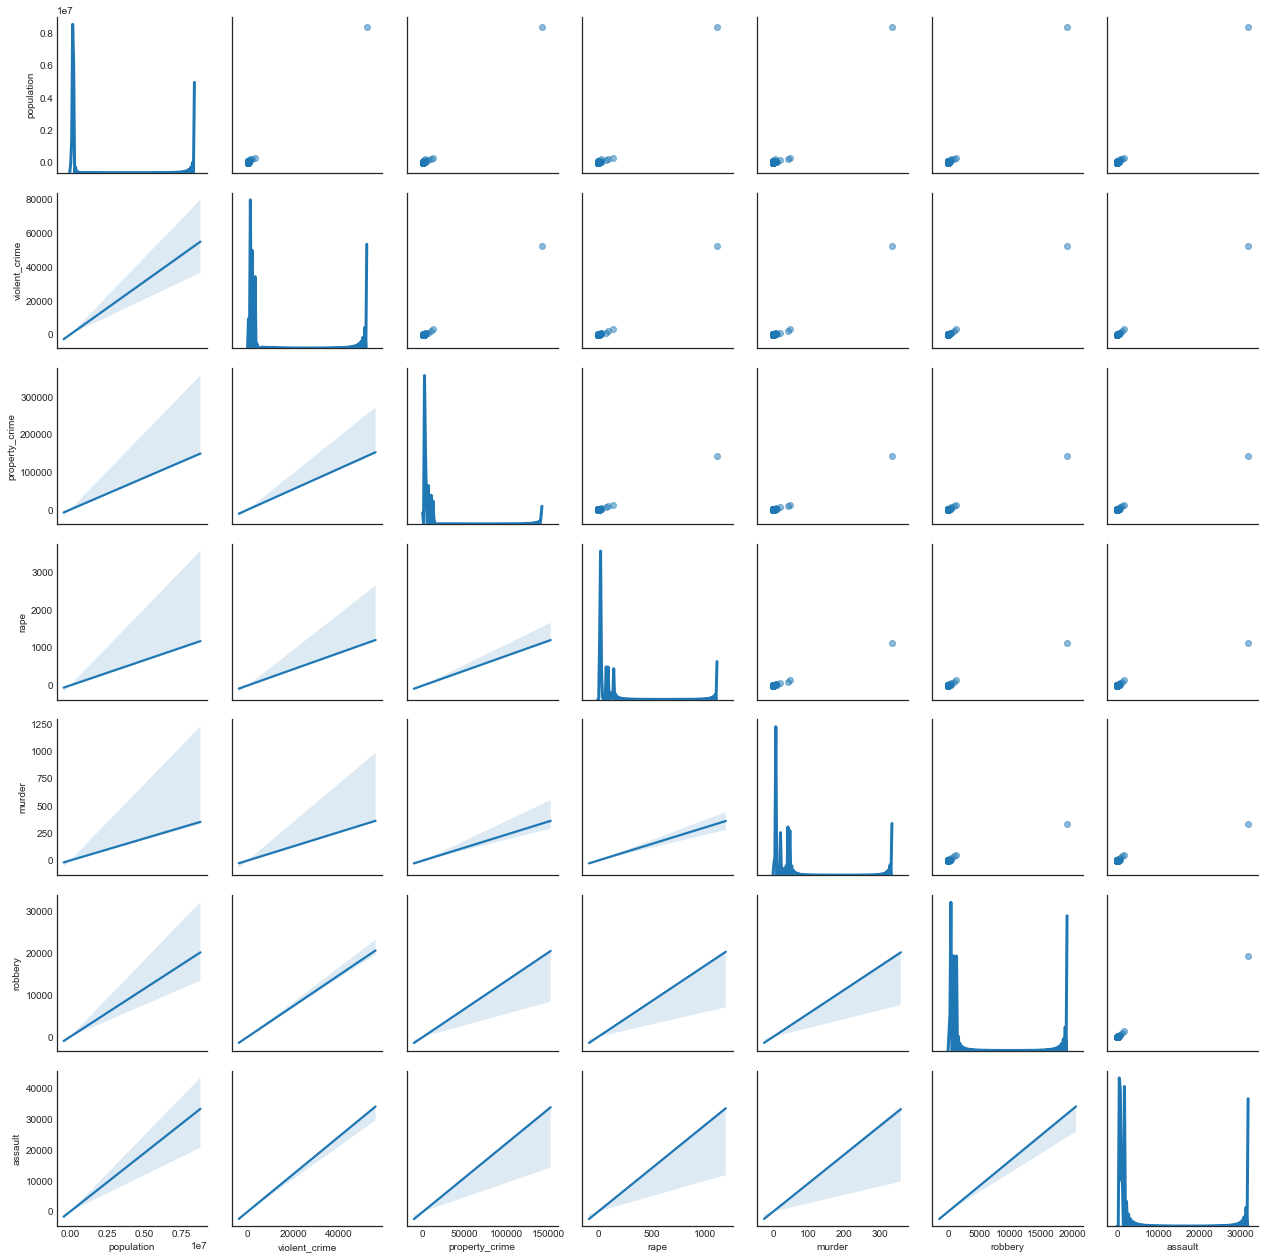

In [2]:
#Make subtable copy of the original data with only the features we want.
df1 = df[['Population', 'Violent\ncrime', 'Property\ncrime', 'Rape\n(legacy\ndefinition)2', 
         'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Aggravated\nassault']].copy()
df1.columns = ['population', 'violent_crime', 'property_crime', 'rape',
               'murder', 'robbery', 'assault']

#Check distribution
g = sns.PairGrid(df1, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

It looks like almost every variable has outliers. I chose to winsorize all of them.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


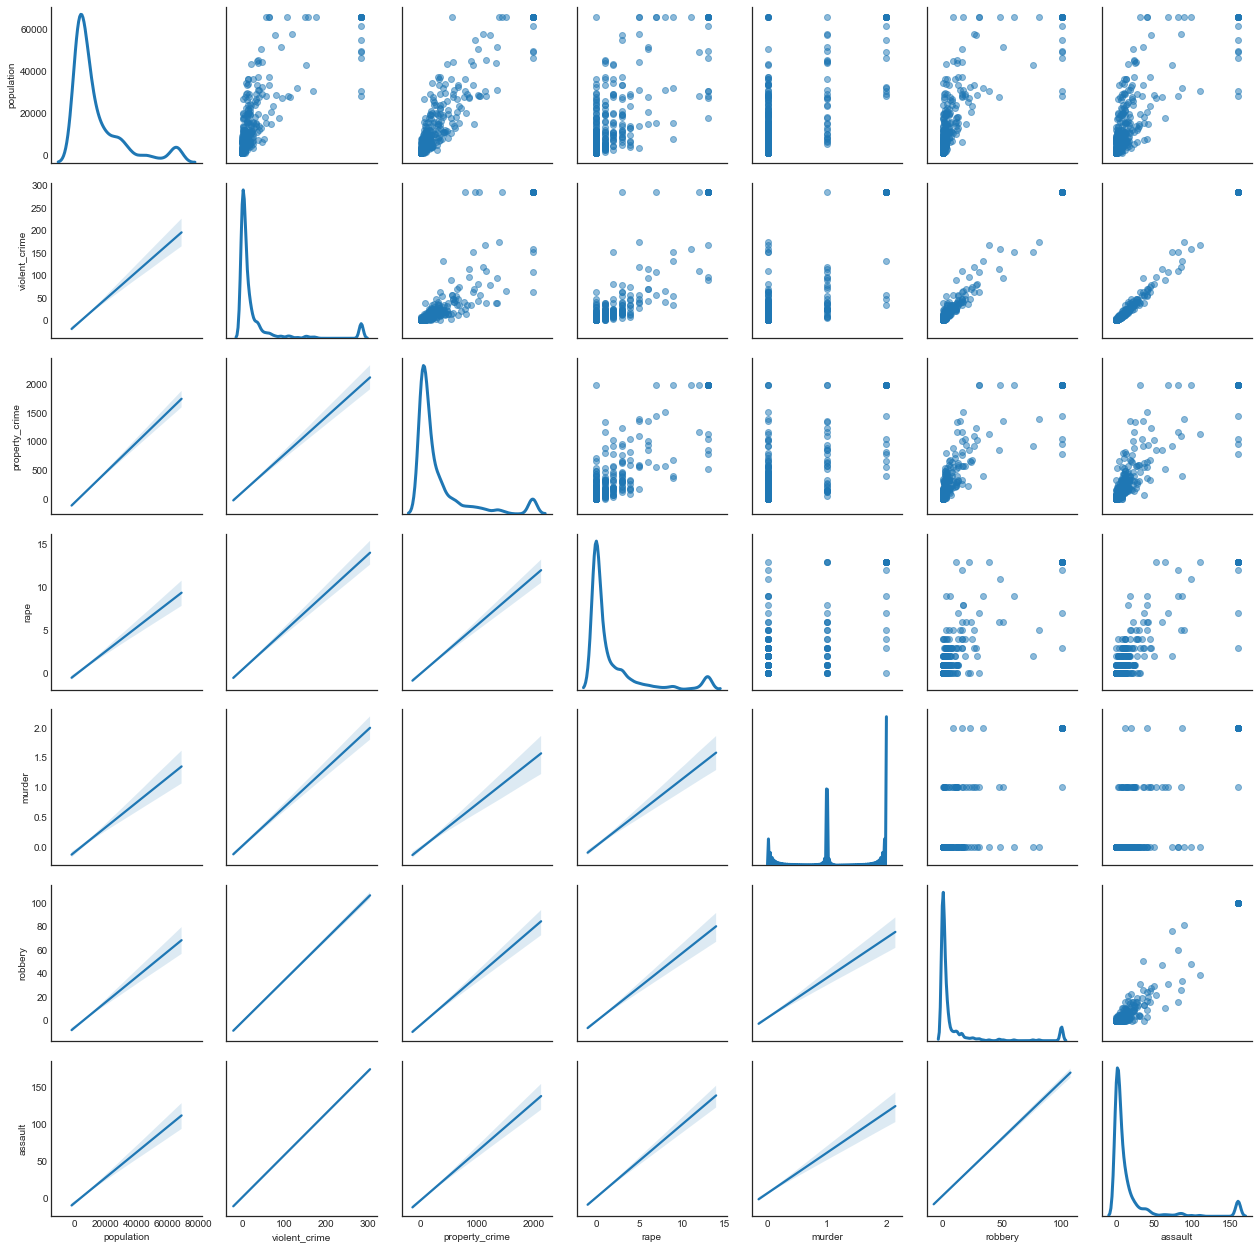

In [3]:
#Apply winsorizing to eliminate outliers
#How often is this used in real life? Does it affect predictions of real life data?
def using_mstats(s):
    return stats.mstats.winsorize(s, limits=[0.05, 0.05])
df_win = df1.apply(using_mstats, axis=0)

#Check distribution again
g = sns.PairGrid(df_win, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

We can of course do more to transform the data. However, let's stop now.

# Feature engineering

In [4]:
#Make a table just for the features
df_x = df_win.drop(columns='property_crime').copy()
corrmax = df_x.corr()
print(corrmax)

               population  violent_crime      rape    murder   robbery  \
population       1.000000       0.786745  0.712587  0.662991  0.783705   
violent_crime    0.786745       1.000000  0.876494  0.794110  0.986042   
rape             0.712587       0.876494  1.000000  0.698030  0.823666   
murder           0.662991       0.794110  0.698030  1.000000  0.777602   
robbery          0.783705       0.986042  0.823666  0.777602  1.000000   
assault          0.782312       0.995929  0.882351  0.786950  0.968371   

                assault  
population     0.782312  
violent_crime  0.995929  
rape           0.882351  
murder         0.786950  
robbery        0.968371  
assault        1.000000  


It looks like violent crimes, rape, robbery and assult are highly correlated. We can do a PCA to reduce these features.

In [6]:
#Choose the features to perform PCA
pca_list = ['violent_crime', 'rape', 'robbery', 'assault']

#Process the data for PCA
df_pca = df_x.loc[:, pca_list]
X = preprocessing.StandardScaler().fit_transform(df_pca)

#Perform the PCA
pca = PCA(n_components=4)
Y_sklearn = pca.fit_transform(X)

#Examine how well the components explain the variables
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [9.42455350e-01 5.12600518e-02 6.23833317e-03 4.62650291e-05]


The first component can already explain 94% of the variance, so we can drop the other three.


Coefficients: 
 [ 1.61010196e-02 -8.33341342e+01  1.27647779e+02]

Intercept: 
 105.68288591258056

R-squared:
0.8979100452343586


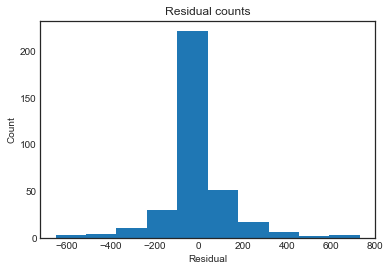

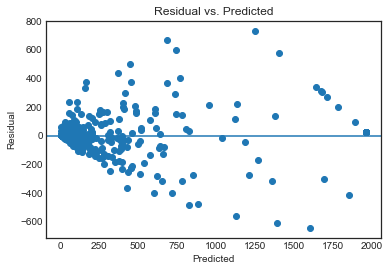

In [7]:
#Add component 1 as a new feature
df_x['PCA_comp1'] = pd.DataFrame(Y_sklearn)[0]
df_x = df_x.drop(columns = pca_list)

#Fit linear regression model
regr = linear_model.LinearRegression()
X = df_x
regr.fit(X, df_win['property_crime'])

#Examine the linear regression model
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, df_win['property_crime']))

#Check the assumptions
predicted = regr.predict(X).ravel()
actual = df_win['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

#Check the multivariate normality
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check the homoscedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


There is also another way of doing the linear regression, which is to do OLS using statsmodel.formula.api

I used it to double check my linear regression model.

In [8]:
#use smf
df_smf = df_x.copy()
df_smf['property_crime'] = df_win['property_crime']
est = smf.ols(
        formula='property_crime ~ population + murder + PCA_comp1',
        data=df_smf).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1017.
Date:                Mon, 11 Jun 2018   Prob (F-statistic):          1.62e-171
Time:                        11:59:13   Log-Likelihood:                -2268.6
No. Observations:                 351   AIC:                             4545.
Df Residuals:                     347   BIC:                             4561.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    105.6829     14.812      7.135      0.000      76.550     134.816
population     0.0161      0.001     20.010      0.000       0.015       0.018
murder       -83.3341     25.516     -3.266      0.001    -133.520     -33.148
PCA_comp1    127.6478      8.557     14.918      0.000     110.818     144.477
==============================================================================
Omnibus:                       54.115   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.223
Skew:                           0.281   Prob(JB):                     6.93e-96
Kurtosis:                       8.445   Cond. No.                     7.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""